# Overview
This notebook is intended to demonstrate the _quarter-five spot_ problem (see e.g. https://users.wpi.edu/~sweekes/GEO/fivespot.html).

In simple terms, consider a domain with no-flow boundary (all neumann = 0). Let the lower-left corner be an injection well ($p_b=1$ on the boundary symmetrically about the corner) and the upper-right corner be a production well ($f=-1$ in that cell).

The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_d = \{\text{"boundary near origin"}\},\quad 
\partial \Omega_n = \partial\Omega \setminus \Omega_d
$$

with data: 
$$
f=0, \quad
\text{ and }\quad  
u_b=0, \quad
p_b = 1
$$
And $f=-1$ at $(1,1)$

$K=1$ in most of the grid, except a strip in the middle where it will be scaled (up or down) by a factor of 1000.

In [1]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [7]:
### Create a rectangle, which will be "inserted" into the grid ###

class Rectangle:
    
    def __init__(self, physdims, foot=np.array([0,0])):
        """ Create a rectangle represented by its vertices in CCW order.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of SW foot of rectangle. Default: (0,0)
        """
        assert(np.all(np.array(physdims) > 0))
        ft = np.array([foot]).T
        hz = np.array([[physdims[0], 0]]).T # Horizontal shift
        vt = np.array([[0, physdims[1]]]).T # Vertical shift
        self.L = np.hstack((ft, ft+hz))
        self.U = np.add(np.flip(self.L, axis=1), vt)
        self.nodes = np.hstack((self.L, self.U))
        
        # Construction assertion:
        #from porepy.geometry.geometry_property_checks import is_ccw_polygon
        #assert(is_ccw_polygon(self.nodes))
        
        
class RectangleByCenter(Rectangle):
    
    def __init__(self, physdims, center):
        """ Create a rectangle from a center coordinate.
        
        See rectangle for more information.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of center of rectangle
        
        """
        c = np.array(center); pd = np.array(physdims)
        
        foot = c - pd/2
        super().__init__(physdims, foot)

In [21]:
def Q5_with_fracture(Nd=[10,10], inflow=1, outflux=-1, 
                     frac_size=np.array([0.81,0.1]), 
                     frac_cntr=np.array([0.5,0.5]), 
                     frac_perm_factor=1e-3):
    """ Solve the quarter-five spot problem with a fracture in the grid
    
    Parameters
    Nd (list): number of cells in each dimension
    inflow (float): Value at Dirichlet boundary condition near Origin
    outflux (float): Value at source-term near (1,1)
    frac_size (np.array 1x2): Size of fracture in x and y direction
    frac_cntr (np.array 1x2): Location of center of fracture
    frac_perm_factor (float): Value of multiplication factor to 
                              permeability tensor in fracture region
    
    Return:
    g (porepy.CartGrid): grid structure
    p ()
    """

    # Setup grid
    #Nx = Ny = 10
    g = pp.CartGrid(Nd, [1,1])
    g.compute_geometry()

    ### Boundary conditions ###

    # Find indices of boundary faces
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

    # Set all boundary faces to Neumann initially
    labels = np.array(['neu']*b_faces.size)

    # Set no-flow condition on all boundaries initially
    bc_val = np.zeros(g.num_faces)

    ### In-flow (Dirichlet) near Origin ###

    # Coordinates and index of face centers
    coord_faces = np.vstack((g.face_centers[0, b_faces], g.face_centers[1, b_faces], np.array(range(b_faces.size))))

    # Find west face closest to (0,0)
    left_face = coord_faces[:,coord_faces[0]==0]
    ind_min_west = int(left_face[2,np.argmin(left_face[1])])
    labels[ind_min_west] = 'dir'

    # Find south face closest to (0,0)
    bot_face = coord_faces[:,coord_faces[1]==0]
    ind_min_south = int(bot_face[2,np.argmin(bot_face[0])])
    labels[ind_min_south] = 'dir'

    # Create BoundaryCondition object
    bc = pp.BoundaryCondition(g, b_faces, labels)

    # Adjust Dirichlet value
    bc_val[[ind_min_west, ind_min_south]] = inflow

    # Permeability
    perm = pp.SecondOrderTensor(np.ones(g.num_cells))

    # source
    f = np.zeros(g.num_cells)
    #f=g.cell_volumes

    # Injection in lower-left corner. Production upper-right
    f[-1] = outflux

    #cell_id = np.arange(g.num_cells)
    #pp.plot_grid(g, alpha=0.5, figsize=(15,12)) #cell_value=cell_id, info='c' for cell numbers
    
    # Create fracture object
    physdims=frac_size
    center=frac_cntr
    R=RectangleByCenter(physdims,center)

        
    nds = np.copy(g.cell_centers)
    nds[2] = np.array(range(g.num_cells)) # Use z-coordinate as index.

    from porepy.geometry.geometry_property_checks import point_in_polygon
    rect_nodes = nds[2, point_in_polygon(R.nodes, nds[[0,1],:], tol=1e-8)].astype(int)

    ### Modify permeability of rectangle nodes ###

    perm.values[:,:,rect_nodes] = perm.values[:,:,rect_nodes]*frac_perm_factor

    # Build problem
    specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

    # Problem solution
    solver = pp.Tpfa("flow")
    solver.discretize(g, data)
    A, b = solver.assemble_matrix_rhs(g, data)

    # Manually descretize rhs (since tpfa does not discretize rhs)
    s = pp.ScalarSource("flow")
    s.discretize(g,data)
    b1 = s.assemble_rhs(g, data)

    # Solve
    p = sps.linalg.spsolve(A, b+b1)
    
    
    ### Temporary flux vector method ###
    
    ### Code copied from tutorials > single-phase_flow ###
    solver_flow = pp.MVEM("flow")
    solver_flow.discretize(g, data)
    A, b_flow = solver_flow.assemble_matrix_rhs(g, data)

    solver_rhs = pp.DualScalarSource("flow")

    data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
    solver_rhs.discretize(g, data)
    _, b_rhs = solver_rhs.assemble_matrix_rhs(g, data)

    up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

    # Extract the normal flux and pressure from the solution
    u_mvem = solver_flow.extract_flux(g, up, data)
    p_mvem = solver_flow.extract_pressure(g, up, data) 

    # For visualisation purpose project the flux on a vector piecewise constant field
    P0u = solver_flow.project_flux(g, u_mvem, data)
    
    return g, p, p_mvem, P0u

In [26]:
g,p,p_mvem, P0u = Q5_with_fracture(Nd=[40,40],frac_perm_factor=1e3)

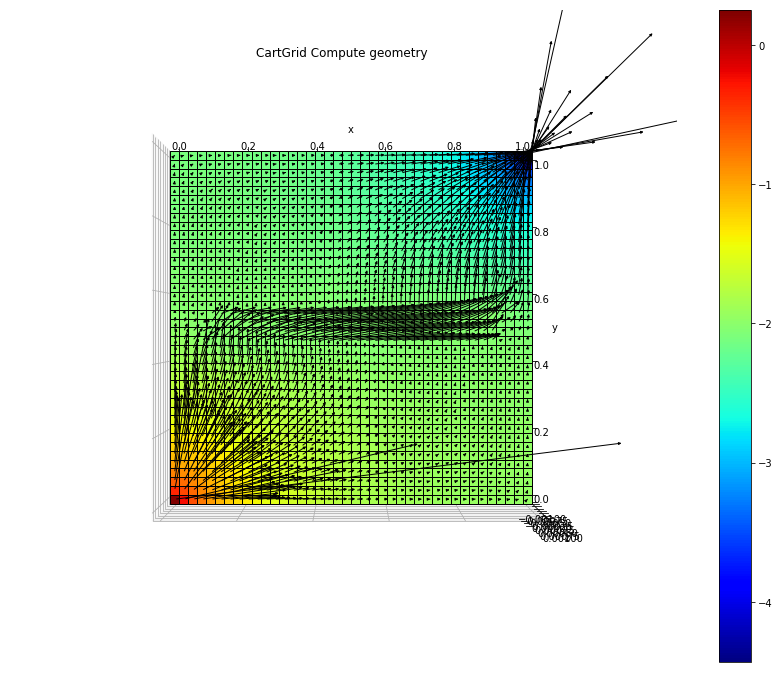

In [27]:
pp.plot_grid(g, p_mvem, P0u*0.035, figsize=(15, 12))

In [16]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)


P0u_normalized = normalized(P0u,0)*0.055